# Energy Demand Forecasting with Granite Timeseries (TTM)

Based on the [Granite-Timeseries-TTM](https://github.com/ibm-granite/granite-tsfm/blob/cookbook-dev/notebooks/recipes/energy_demand_forecasting/demand_forecast_zeroshot_recipe.ipynb) notebook.

### Install the TSFM Library 
NOTE: For Python 3.12 and above, you will need to install `setuptools`, which provides `distutils`.

In [15]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+ssh://git@github.com/ibm-granite/granite-tsfm.git@cookbook-dev"

# Install setuptools to get distutils.
! pip install setuptools

  Cloning ssh://****@github.com/ibm-granite/granite-tsfm.git (to revision cookbook-dev) to /private/var/folders/nc/jrql4k0n2j73h7xktzxdr4pr0000gn/T/pip-install-1qn1dxxy/tsfm-public_a311719bce4a4dce94e88d784fe947ea
  Running command git clone --filter=blob:none --quiet 'ssh://****@github.com/ibm-granite/granite-tsfm.git' /private/var/folders/nc/jrql4k0n2j73h7xktzxdr4pr0000gn/T/pip-install-1qn1dxxy/tsfm-public_a311719bce4a4dce94e88d784fe947ea
  Running command git checkout -b cookbook-dev --track origin/cookbook-dev
  Switched to a new branch 'cookbook-dev'
  Branch 'cookbook-dev' set up to track remote branch 'cookbook-dev' from 'origin'.
  Resolved ssh://****@github.com/ibm-granite/granite-tsfm.git to commit 07eb7f217bdc4ef08894cbc67c9efe42a745732b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Import Packages

In [16]:
import tsfm_public
tsfm_public.__version__

'0.2.9.dev24+g07eb7f2'

In [47]:
import pandas as pd
import os

from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TimeSeriesForecastingPipeline,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
# from tsfm_public.toolkit.visualization import plot_predictions
from tsfm_public.toolkit.time_series_preprocessor import prepare_data_splits, create_timestamps

### Download the data

Download energy_data.csv.zip from Kaggle [here](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather), and set the path to the data file.


In [34]:
DATA_FILE_PATH = "~/Downloads/energy_dataset.csv.zip"
temp_dir = "/tmp"

### Specify time and output variables


In [6]:
timestamp_column = "time"
target_columns = ["total load actual", "price actual"]
id_columns = []
control_columns = []

### Read in the Data

In [5]:
df_tmp = pd.read_csv(
  DATA_FILE_PATH
)
df_tmp.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


### Plot the target Series

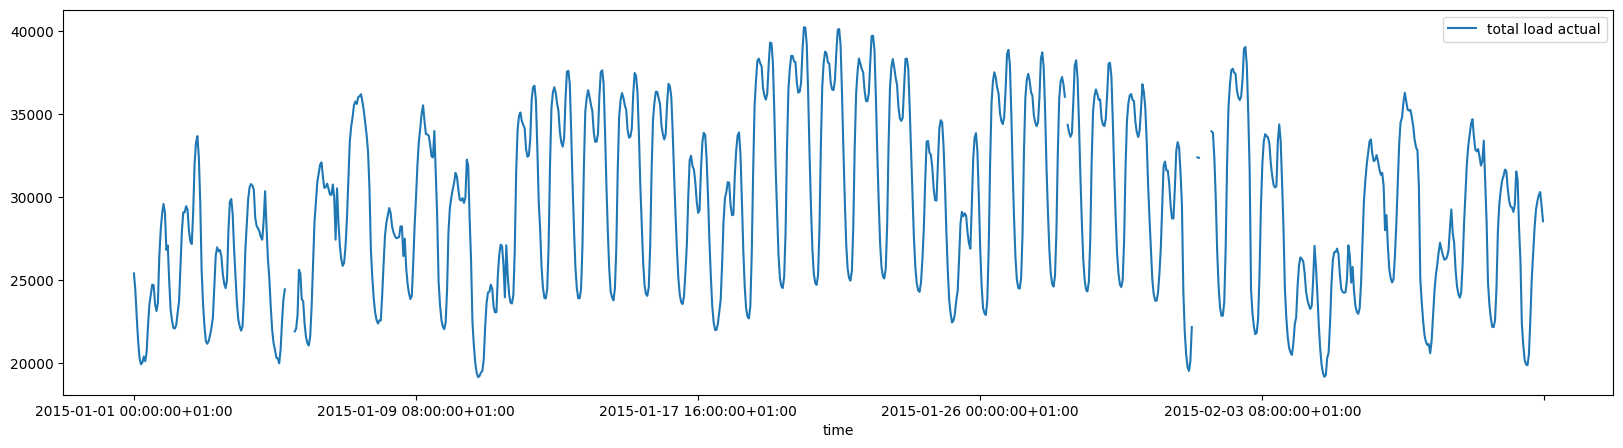

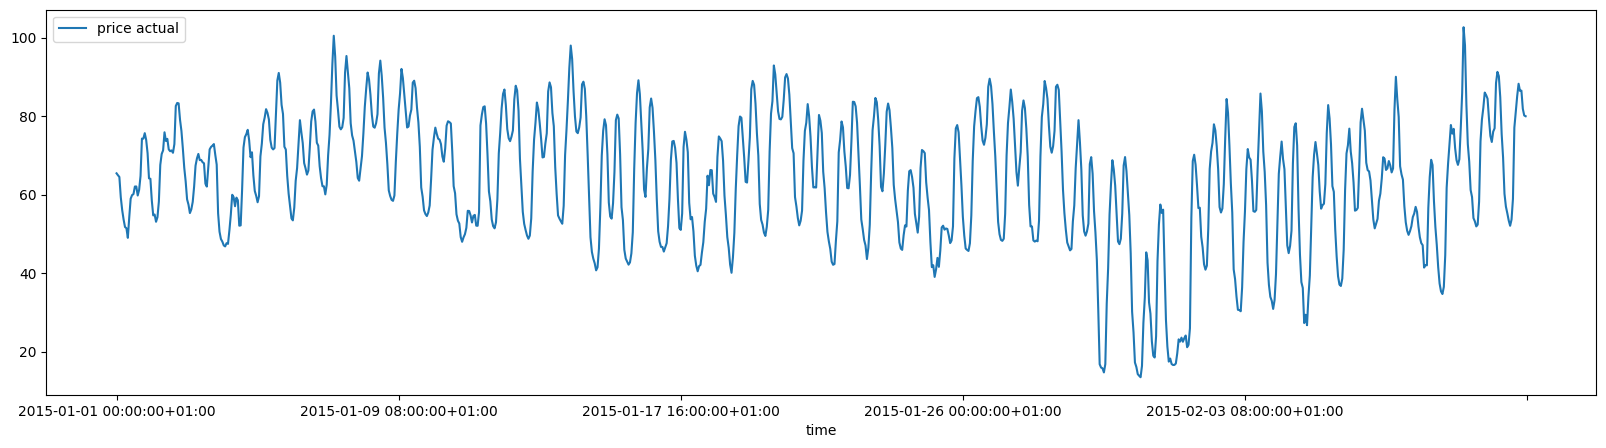

In [24]:
for target_column in target_columns:
  df_tmp.iloc[:1000].plot(x=timestamp_column, y=target_column, figsize=(20, 5))

## Prepare the Data

In [30]:
params = dict(
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    control_columns=[],
    context_length=512,
    prediction_length=96,
    freq="D",
)

tsp = TimeSeriesPreprocessor(
    **params,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

tsp = tsp.train(df_tmp)

prepared_dataset = tsp.preprocess(df_tmp)
# Convert the timestamp column to a datetime
prepared_dataset[timestamp_column] = pd.to_datetime(prepared_dataset[timestamp_column], utc=True)
prepared_dataset.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,-0.723934,50.10,0.529854
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,-0.943172,48.10,0.495356
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,-1.303397,47.33,0.464379
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,-1.619905,42.27,0.101098
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,-1.843297,38.41,-0.129825


### Set up zero shot model

In [31]:
# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
  "ibm-granite/granite-timeseries-ttm-v1", 
  revision=TTM_MODEL_REVISION,
  num_input_channels=tsp.num_input_channels,
  prediction_channel_indices=tsp.prediction_channel_indices,
)

model_parameters = sum(
  p.numel() for p in zeroshot_model.parameters() if p.requires_grad
)
print("TTM Model Parameters:", model_parameters)

TTM Model Parameters: 805280


### Create a forecasting pipeline and evaluate model performance.

Specify your local GPU device with the `device` parameter.

In [32]:
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=target_columns,
    control_columns=[],
    batch_size=2000,
    feature_extractor=tsp,
    device="mps",
)

zeroshot_forecast = pipeline(prepared_dataset, inverse_scale_outputs=True)
zeroshot_forecast.head()

,time,total load actual_prediction,price actual_prediction,total load actual,price actual
0,2015-01-22 06:00:00,"[34993.52091125729, 36074.98903216078, 36647.4...","[62.48905701128217, 68.35301012149202, 71.3864...","[36206.9999063992, 37520.99992269377, 38343.99...","[70.71999960706641, 73.93000061604192, 78.6099..."
1,2015-01-22 07:00:00,"[37518.90241706565, 37625.172217944266, 37511....","[72.97455577981926, 74.87832032135108, 73.8875...","[37520.99992269377, 38343.99983121278, 38053.9...","[73.93000061604192, 78.60999927028897, 77.1300..."
2,2015-01-22 08:00:00,"[38305.915324446505, 37849.16956690412, 37351....","[75.4758644811673, 74.3138992154631, 71.521131...","[38343.99983121278, 38053.99977200011, 37705.9...","[78.60999927028897, 77.13000053525019, 70.9800..."
3,2015-01-22 09:00:00,"[38563.31078759269, 37904.43987641439, 37184.2...","[76.33822374895607, 73.14692028230763, 69.9037...","[38053.99977200011, 37705.999810019566, 37512....","[77.13000053525019, 70.98000000264528, 67.0900..."
4,2015-01-22 10:00:00,"[37682.1053705799, 37088.52000379353, 36234.38...","[73.23461628522404, 69.98276105845255, 67.2033...","[37705.999810019566, 37512.99984207522, 36419....","[70.98000000264528, 67.09000023843305, 61.6799..."


### Evaluate the model

In [36]:
import numpy as np

def compute_metric(actual, prediction):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    mask = ~np.any(np.isnan(a), axis=1)  # ~np.isnan(a)
    p = np.asarray(prediction.tolist())
    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    return dict(mean_squared_error=mse, root_mean_squared_error=np.sqrt(mse))

compute_metric(zeroshot_forecast["total load actual"], zeroshot_forecast["total load actual_prediction"])

{'mean_squared_error': 8794331.075921977,
 'root_mean_squared_error': 2965.523743948441}

### Make and plot predictions on the test set, along with the actuals

In [ ]:
### Plot predictions
for target_column in target_columns:
  zeroshot_forecast.plot(x=timestamp_column, y=target_column + "_prediction", figsize=(20, 5))

In [50]:
from typing import List, Optional
import matplotlib.pyplot as plt

def plot_predictions(
    ground_truth_df: pd.DataFrame,
    predictions: pd.DataFrame,
    freq: str,
    timestamp_column: str,
    id_columns: Optional[List[str]] = None,
    plot_dir: str = None,
    num_plots: int = 10,
    plot_prefix: str = "valid",
    channel: str = None,
    truncate_history: bool = True,
):
    """Utility for plotting forecasts along with history.

    Args:
        model (torch.nn.Module): A trained model.
        dset (torch.utils.data.Dataset): Dataset that was fed into Trainer for predicting
        plot_dir (str, optional): A location to save the plot. If None, no plot is saved. Defaults to None.
        num_plots (int, optional): Number of sub-plots (context windows) to include. Defaults to 10.
        plot_prefix (str, optional): A prefix for the saved filename. Defaults to "valid".
        channel (int, optional): Which channels to plot for a multivariate dataset. Defaults to -1.
        truncate_history (bool, optional): If True only some hisotry (2 * pred_len samples) will be included in the plot. Defaults to True.
    """
    # device = torch.cuda.current_device() if torch.cuda.is_available() else torch.device("cpu")
    # device = model.device
    random_indices = np.random.choice(len(predictions), size=num_plots, replace=False)
    # ground_truth_subset = [ground_truth.iloc[i].values for i in random_indices]
    predictions_subset = [predictions.iloc[i] for i in random_indices]

    #y_hat = output.prediction_outputs[:, :, channel].detach().cpu().numpy()

    pred_len = len(predictions_subset[0][channel])

    # Set a more beautiful style
    plt.style.use("seaborn-v0_8-whitegrid")

    # Adjust figure size and subplot spacing
    assert num_plots >= 1
    fig, axs = plt.subplots(num_plots, 1, figsize=(10, 2 * num_plots))
    if num_plots == 1:
        axs = [axs]

    for i, ri in enumerate(random_indices):
        ts = create_timestamps(predictions_subset[i][timestamp_column], freq=freq, periods=pred_len)
        y_hat = predictions_subset[i][f"{channel}_prediction"]
        y = predictions_subset[i][f"{channel}"]

        # y = batch["future_values"][:pred_len, channel].squeeze().cpu().numpy()
        # if truncate_history:
        #     x = batch["past_values"][-2 * pred_len :, channel].squeeze().cpu().numpy()
        # else:
        #     x = batch["past_values"][:, channel].squeeze().cpu().numpy()
        # y = np.concatenate((x, y), axis=0)

        # Plot predicted values with a dashed line
        # y_hat_plot = np.concatenate((x, y_hat[i, ...]), axis=0)
        axs[i].plot(ts, y_hat, label="Predicted", linestyle="--", color="orange", linewidth=2)

        # Plot true values with a solid line
        axs[i].plot(ts, y, label="True", linestyle="-", color="blue", linewidth=2)

        # Plot horizon border
        # axs[i].axvline(x=2 * pred_len, color="r", linestyle="-")

        axs[i].set_title(f"Example {random_indices[i]}")
        axs[i].legend()

    # Adjust overall layout
    plt.tight_layout()

    # Save the plot
    if plot_dir is not None:
        plot_filename = f"{plot_prefix}_ch_{str(channel)}.pdf"
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, plot_filename))

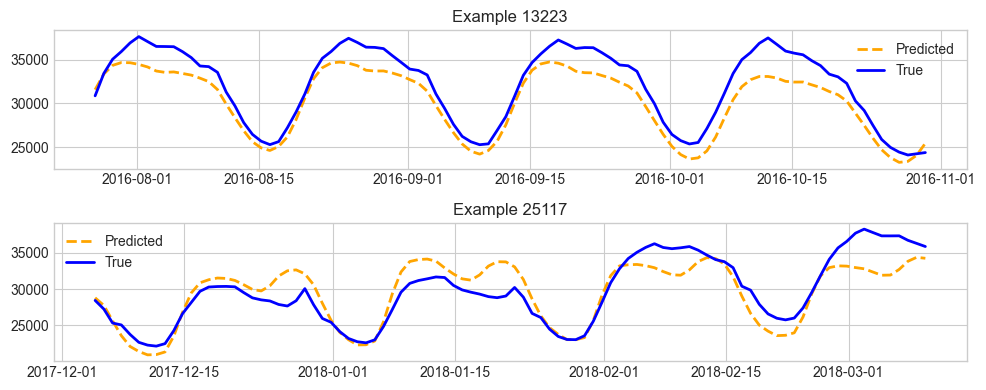

In [51]:
plot_predictions(prepared_dataset,
    zeroshot_forecast,
    timestamp_column=timestamp_column,
    freq=tsp.freq,
    plot_dir = None,
    num_plots = 2,
    plot_prefix = "Test",
    channel = "total load actual",
    truncate_history = True,
)